In [1]:
import os
from torchvision import transforms
import numpy as np
import cv2
from PIL import Image, ImageDraw, ImageFont
import torch
import torch.nn as nn
import importlib
import pandas as pd
import functions as fc
import random
import pickle
import time
import matplotlib.pyplot as plt
import sys
import pickle
sys.path.append('./objectDetectionModule/')
from utils import *
from objectDetectionModule.model import SSD300, MultiBoxLoss

# load data

In [14]:
label_color_map = {
    'aquarium': '#e6194b',
     'bottle': '#3cb44b',
     'bowl': '#ffe119',
     'box': '#0082c8',
     'bucket': '#f58231',
     'plastic_bag': '#911eb4',
     'plate': '#46f0f0',
     'styrofoam': '#f032e6',
     'tire': '#d2f53c',
     'toilet': '#fabebe',
     'tub': '#008080',
     'washing_machine': '#000080',
     'water_tower': '#aa6e28',
     'background': '#FFFFFF'
    }

In [2]:
rev_label_map = {1:'aquarium'
                ,2:'bottle'
                ,3:'bowl'
                ,4:'box'
                ,5:'bucket'
                ,6:'plastic_bag'
                ,7:'plate'
                ,8:'styrofoam'
                ,9:'tire'
                ,10:'toilet'
                ,11:'tub'
                ,12:'washing_machine'
                ,13:'water_tower'
                ,0:'background'}

In [3]:
label_map = {'aquarium':1
         ,'bottle':2
         ,'bowl':3
         ,'box':4
         ,'bucket':5
         ,'plastic_bag':6
         ,'plate':7
         ,'styrofoam':8
         ,'tire':9
         ,'toilet':10
         ,'tub':11
         ,'washing_machine':12
         ,'water_tower':13
         ,'background':0}

In [4]:
path = './dataSet/test_cdc/test_images/'
with open('./dataSet/test_cdc/datas.pickle', 'rb') as f:
    datas = pickle.load(f)

testDatas = []
for i, j in enumerate(datas):
    testDatas.append(path + datas[i][0])

# detect

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model checkpoint
checkpoint = './models/checkpoint_ssd300.pth.tar'
checkpoint = torch.load(checkpoint)
start_epoch = checkpoint['epoch'] + 1
print('\nLoaded checkpoint from epoch %d.\n' % start_epoch)
model = checkpoint['model']
model = model.to(device)
model.eval()

# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])


Loaded checkpoint from epoch 53.



In [6]:
def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.
    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(predicted_locs, predicted_scores, min_score=min_score,
                                                             max_overlap=max_overlap, top_k=top_k)

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [original_image.width, original_image.height, original_image.width, original_image.height]).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ['background']:
        # Just return original image
        return 0

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./calibril.ttf", 15)

    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(xy=[l + 1. for l in box_location], outline=label_color_map[
            det_labels[i]])  # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        text_size = font.getsize(det_labels[i].upper())
        text_location = [box_location[0] + 2., box_location[1] - text_size[1]]
        textbox_location = [box_location[0], box_location[1] - text_size[1], box_location[0] + text_size[0] + 4.,
                            box_location[1]]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill='white',
                  font=font)
    del draw

    return annotated_image, det_boxes, det_labels

In [33]:
finalList = []
for img_path in testDatas:
    original_image = Image.open(img_path, mode='r')
    original_image = original_image.convert('RGB')
    outputs = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)
    if outputs == 0:
        continue
    name = img_path.split('/')[-1]
    
    labelx = []
    for i in outputs[2]:
        labelx.append(label_map[i])
    
    loc = outputs[1].cpu().detach().numpy()
    loc = loc.astype(int)
    loc[:, 2] = loc[:, 2] - loc[:, 0]
    loc[:, 3] = loc[:, 3] - loc[:, 1]
    
    cc = [name, labelx, loc]
    finalList.append(cc)
    break


In [39]:
finalList2 = []
for i in finalList:
    ln = len(i[1])
    l = np.array(i[1]).reshape(-1, 1)   # labelx
    l2 = i[2]          # loc
    l3 = [i[0]] * ln
    l3 = np.array(l3).reshape(-1, 1)  # name
    l4 = np.array(l3).reshape(-1, 1)
    l5 = np.concatenate([l3, l, l2], axis=1)
    finalList2.append(l5)


In [49]:
final3 = np.concatenate(finalList2, axis=0)
n = final3.shape[0]
ff = (np.zeros(n) + 0.99).reshape(-1, 1)
final4 = np.concatenate([final3, ff], axis=1)

In [51]:
dataFrame = pd.DataFrame(final4, columns=['image_filename', 'label_id', 'x', 'y', 'w', ' h', 'confidence'])

In [53]:
dataFrame.to_csv('./outputs/output1.csv', index=False)

In [29]:
labelx

[3, 3, 5, 5, 5]

In [26]:
outputs[2]

['bowl', 'bowl', 'bucket', 'bucket', 'bucket']

In [25]:
ll[:, 2] = ll[:, 2] - ll[:, 0]
ll[:, 3] = ll[:, 3] - ll[:, 1]
ll

array([[322, 347,  58,  53],
       [ 10, 490,  72,  53],
       [453, 319, 172, 279],
       [321, 342,  57,  56],
       [347, 108,  95, 142]])

In [21]:
loc

array([[322, 347, 380, 400],
       [ 10, 490,  82, 543],
       [453, 319, 625, 598],
       [321, 342, 378, 398],
       [347, 108, 442, 250]])

In [19]:
img_path.split('/')[-1]

'200801213.jpg'

In [15]:
img_path = testDatas[0]
original_image = Image.open(img_path, mode='r')
original_image = original_image.convert('RGB')
outputs = detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200)

In [30]:
outputs[0].show()

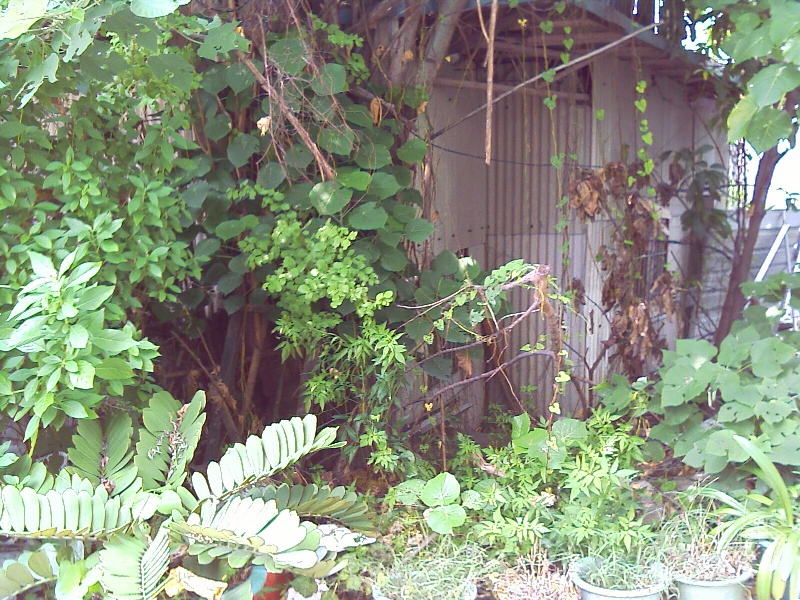

In [8]:
outputs